In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vgg16
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:

# Transform to 3 channels and resize images to 224x224 (VGG16 input size)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [4]:
# Load pre-trained VGG16 model
model = vgg16(pretrained=True)
model.eval()  # Set to evaluation mode

# Remove the classifier (fc layers) to get features from the last conv layer
feature_extractor = nn.Sequential(*list(model.features.children())[:-1])

/Users/swathibaskaran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swathibaskaran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def extract_features(loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            outputs = model(images)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
            labels.append(targets.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)

100%|█████████████████████████████████████████| 157/157 [08:29<00:00,  3.25s/it]


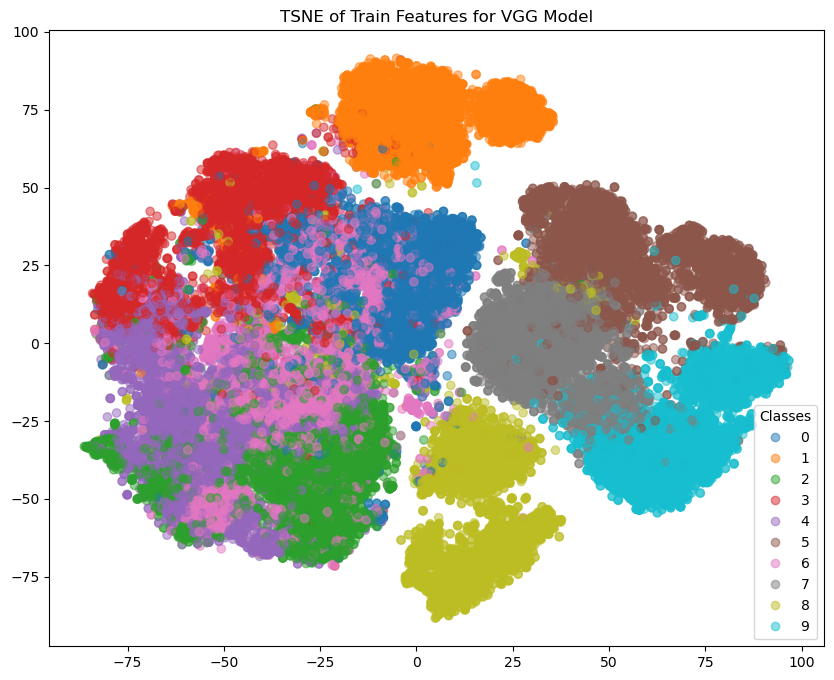

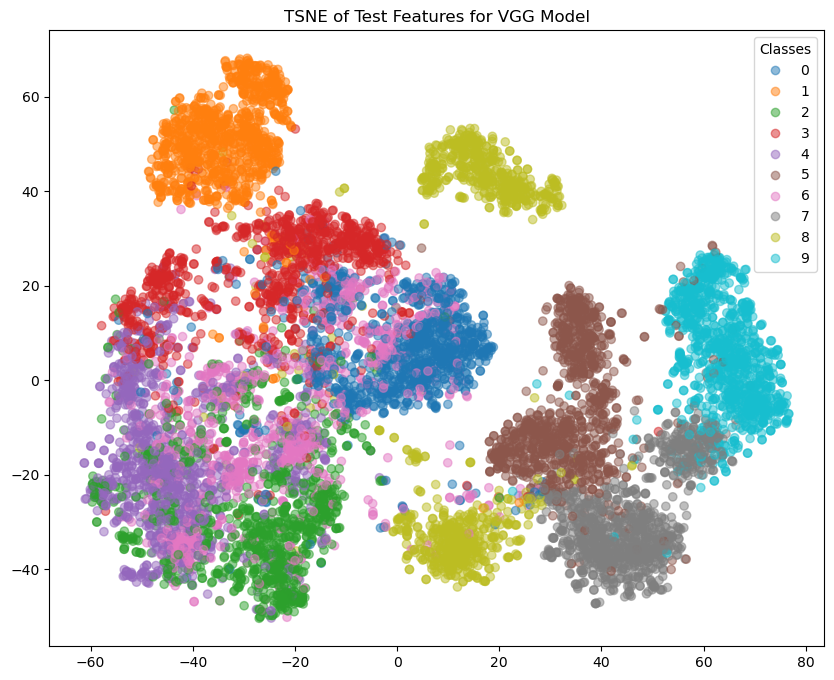

In [6]:
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_result = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

plot_tsne(train_features, train_labels, "TSNE of Train Features for VGG Model")
plot_tsne(test_features, test_labels, "TSNE of Test Features for VGG Model")